In [1]:
import os
import pandas as pd
import scipy
import math
import numpy as np
import cv2
import keras
import seaborn as sns
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
import PIL.Image


In [2]:
### LOADING DATASET
data_dir = os.path.abspath('D:/Abhijeet/code/new/GTSRB/Final_Training/Images')
os.path.exists(data_dir)

True

In [3]:
### Function to resize the images using open cv
def resize_cv(im):
    return cv2.resize(im, (64, 64), interpolation = cv2.INTER_LINEAR)

In [4]:
### Loading datset
list_images = []
output = []
for dir in os.listdir(data_dir):
    if dir == '.DS_Store' :
        continue
    
    inner_dir = os.path.join(data_dir, dir)
    csv_file = pd.read_csv(os.path.join(inner_dir,"GT-" + dir + '.csv'), sep=';')
    for row in csv_file.iterrows() :
        img_path = os.path.join(inner_dir, row[1].Filename)
        img = cv2.imread(img_path)
        img = img[row[1]['Roi.X1']:row[1]['Roi.X2'],row[1]['Roi.Y1']:row[1]['Roi.Y2'],:]
        img = resize_cv(img)
        list_images.append(img)
        output.append(row[1].ClassId)

C:\Users\Home\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


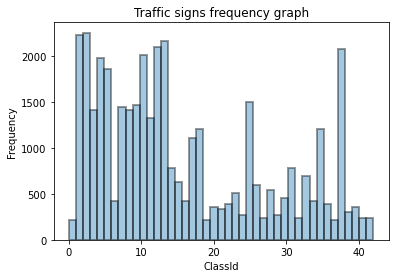

In [5]:
### Plotting the dataset
fig = sns.distplot(output, kde=False, bins = 43, hist = True, hist_kws=dict(edgecolor="black", linewidth=2))
fig.set(title = "Traffic signs frequency graph",
        xlabel = "ClassId",
        ylabel = "Frequency")

input_array = np.stack(list_images)

train = keras.utils.to_categorical(output)



In [6]:
# Load sign names file
sign_names = pd.read_csv("D:/Abhijeet/code/new/data/labels/labels.csv")
sign_names.set_index("ClassId")
sign_names.head((len(set(output))+1))

,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [7]:
### Randomizing the dataset
randomize = np.arange(len(input_array))
np.random.shuffle(randomize)
x = input_array[randomize]
y = train[randomize]

In [8]:
### Splitting the dataset in train, validation, test set
split_size = int(x.shape[0]*0.6)
train_x, val_x = x[:split_size], x[split_size:]
train_y, val_y = y[:split_size], y[split_size:]

split_size = int(val_x.shape[0]*0.5)
val_x, test_x = val_x[:split_size], val_x[split_size:]
val_y, test_y = val_y[:split_size], val_y[split_size:]

In [9]:
# Total Number of examples
img_count=len(list(output))

# Number of training examples
n_train = train_x.shape[0]

# Number of validation examples
n_validation = val_x.shape[0]

# Number of testing examples.
n_test = test_x.shape[0]

# What's the shape of an traffic sign image?
image_shape = train_x.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(output))


print("Total Number of examples =", img_count)
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Total Number of examples = 39209
Number of training examples = 23525
Number of validation examples = 7842
Number of testing examples = 7842
Image data shape = (64, 64, 3)
Number of classes = 43


In [10]:
data=pd.read_csv('D:/Abhijeet/code/new/data/labels/labels.csv')
print("data shape ",data.shape,type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


In [11]:
samp_img=input_array[500]

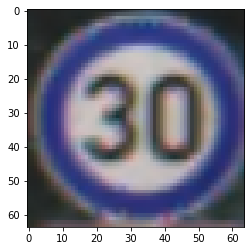

In [13]:
plt.imshow(samp_img)

In [14]:
### Building the model
hidden_num_units = 2048
hidden_num_units1 = 1024
hidden_num_units2 = 128
output_num_units = 43

epochs = 10
batch_size = 16
pool_size = (2, 2)
input_shape = Input(shape=(32, 32,3))

model = Sequential([

 Conv2D(16, (3, 3), activation='relu', input_shape=(64,64,3), padding='same'),
 BatchNormalization(),

 Conv2D(16, (3, 3), activation='relu', padding='same'),
 BatchNormalization(),
 MaxPooling2D(pool_size=pool_size),
 Dropout(0.2),
    
 Conv2D(32, (3, 3), activation='relu', padding='same'),
 BatchNormalization(),
    
 Conv2D(32, (3, 3), activation='relu', padding='same'),
 BatchNormalization(),
 MaxPooling2D(pool_size=pool_size),
 Dropout(0.2),
    
 Conv2D(64, (3, 3), activation='relu', padding='same'),
 BatchNormalization(),
    
 Conv2D(64, (3, 3), activation='relu', padding='same'),
 BatchNormalization(),
 MaxPooling2D(pool_size=pool_size),
 Dropout(0.2),

 Flatten(),

 Dense(units=hidden_num_units, activation='relu'),
 Dropout(0.3),
 Dense(units=hidden_num_units1, activation='relu'),
 Dropout(0.3),
 Dense(units=hidden_num_units2, activation='relu'),
 Dropout(0.3),
 Dense(units=output_num_units, input_dim=hidden_num_units, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])


In [15]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4

In [16]:
### Training the model
trained_model_conv = model.fit(train_x.reshape(-1,64,64,3), train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_x, val_y))                               


Epoch 1/10
1471/1471 [==============================] - 870s 591ms/step - loss: 2.7157 - accuracy: 0.2827 - val_loss: 1.0759 - val_accuracy: 0.6936
Epoch 2/10
1471/1471 [==============================] - 681s 463ms/step - loss: 0.9712 - accuracy: 0.7114 - val_loss: 0.3499 - val_accuracy: 0.8948
Epoch 3/10
1471/1471 [==============================] - 677s 460ms/step - loss: 0.4074 - accuracy: 0.8768 - val_loss: 0.1522 - val_accuracy: 0.9535
Epoch 4/10
1471/1471 [==============================] - 590s 401ms/step - loss: 0.2189 - accuracy: 0.9319 - val_loss: 0.0819 - val_accuracy: 0.9772
Epoch 5/10
1471/1471 [==============================] - 561s 381ms/step - loss: 0.1440 - accuracy: 0.9553 - val_loss: 0.0744 - val_accuracy: 0.9782
Epoch 6/10
1471/1471 [==============================] - 577s 392ms/step - loss: 0.1027 - accuracy: 0.9676 - val_loss: 0.0547 - val_accuracy: 0.9856
Epoch 7/10
1471/1471 [==============================] - 602s 409ms/step - loss: 0.0683 - accuracy: 0.9791 - val_

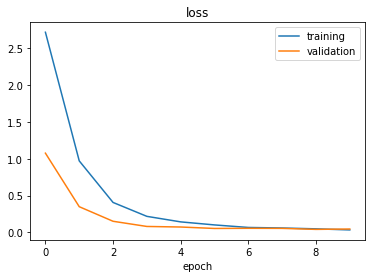

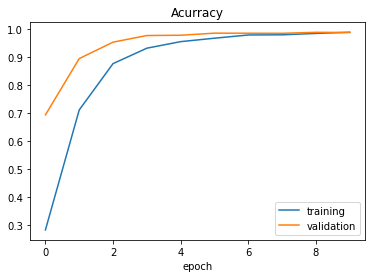

Test Score: 0.0402289554476738
Test Accuracy: 0.989670991897583


In [17]:
############################### PLOT
plt.figure(1)
plt.plot(trained_model_conv.history['loss'])
plt.plot(trained_model_conv.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(trained_model_conv.history['accuracy'])
plt.plot(trained_model_conv.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()

### Evaluating the model
score =model.evaluate(test_x,test_y,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

In [18]:
### Evaluating the model
model.evaluate(test_x, test_y)
print('evaluate done')

246/246 [==============================] - 27s 111ms/step - loss: 0.0402 - accuracy: 0.9897
evaluate done


In [21]:
### Saving the Model
model.save('finalmodel.h5')

In [22]:
from keras.preprocessing import image 

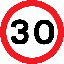

In [23]:
### testing model
t_img=image.load_img(r'D:/Abhijeet/code/OIP (2).jfif',target_size=(64,64,3))

t_img

In [24]:
t_img=image.img_to_array(t_img)

t_img=np.expand_dims(t_img,axis=0)

print((model.predict_classes(t_img)))

[1]
